# Part 4: Convolutional Neural Networks

In this example, we replace the neural networks used in the [previous notebook](3_neural_networks.ipynb) for classifying mnist.

# Setup

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [17]:
# Settings
NUM_WORKERS = 2
NUM_CLASSES = 10

# Hyperparameters
BATCH_SIZE = 4
IMG_SIZE = 28 # Modify image dimensions to RESIZE x RESIZE
NUM_EPOCH = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9

# Prepare Data

In [18]:
# Create training dataloader
train_set = torchvision.datasets.MNIST(root='./data', 
                                       train=True, 
                                       transform=transforms.ToTensor(), 
                                       download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

# Create testing dataloader
test_set = torchvision.datasets.MNIST(root='./data', 
                                      train=False, 
                                      transform=transforms.ToTensor(), 
                                      download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [19]:
print('Number of training samples:', len(train_set))
print('Number of testing samples:', len(test_set))

Number of training samples: 60000
Number of testing samples: 10000


Shape: torch.Size([1, 28, 28])


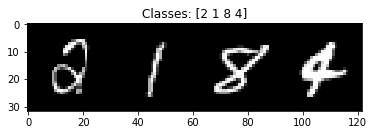

In [20]:
# Load one data batch
inputs, classes = next(iter(train_loader))

# Print image shape
print('Shape:', inputs[0].shape)

# Visualize the data batch
out = torchvision.utils.make_grid(inputs)
plt.imshow(out.permute(1, 2, 0))
plt.title('Classes: ' + str(classes.numpy()))
plt.show()

# Model

Now we are going to use a **convolutional neural network** to classify our images. The convolutional neural network consists of **convolutional** layers, **ReLU** activation layers and **max pooling** layers.

<img src="images/CNN_architecture.jpeg">

In [21]:
# Simple convolutional net
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 input channel, 6 output channels, 3x3 convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * IMG_SIZE//4 * IMG_SIZE//4, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NUM_CLASSES)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(BATCH_SIZE, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
net = ConvNet()

# Send model to GPU
net = net.cuda() 

# Loss Function

In [23]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimizer

In [24]:
# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Training the Model

In [30]:
for epoch in range(NUM_EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0): # learn from 1 batch
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Send data to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = net(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('Epoch: %d | Batch: %5d | Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Epoch: 1 | Batch:  2000 | Loss: 0.652
Epoch: 1 | Batch:  4000 | Loss: 0.242
Epoch: 1 | Batch:  6000 | Loss: 0.199
Epoch: 1 | Batch:  8000 | Loss: 0.205
Epoch: 1 | Batch: 10000 | Loss: 0.184
Epoch: 1 | Batch: 12000 | Loss: 0.158
Epoch: 1 | Batch: 14000 | Loss: 0.157
Epoch: 2 | Batch:  2000 | Loss: 0.170
Epoch: 2 | Batch:  4000 | Loss: 0.156
Epoch: 2 | Batch:  6000 | Loss: 0.168
Epoch: 2 | Batch:  8000 | Loss: 0.184
Epoch: 2 | Batch: 10000 | Loss: 0.189
Epoch: 2 | Batch: 12000 | Loss: 0.172
Epoch: 2 | Batch: 14000 | Loss: 0.181
Epoch: 3 | Batch:  2000 | Loss: 0.174
Epoch: 3 | Batch:  4000 | Loss: 0.194
Epoch: 3 | Batch:  6000 | Loss: 0.269
Epoch: 3 | Batch:  8000 | Loss: 0.230
Epoch: 3 | Batch: 10000 | Loss: 0.215
Epoch: 3 | Batch: 12000 | Loss: 0.237
Epoch: 3 | Batch: 14000 | Loss: 0.293
Epoch: 4 | Batch:  2000 | Loss: 0.266
Epoch: 4 | Batch:  4000 | Loss: 0.245
Epoch: 4 | Batch:  6000 | Loss: 0.282
Epoch: 4 | Batch:  8000 | Loss: 0.449
Epoch: 4 | Batch: 10000 | Loss: 0.371
Epoch: 4 | B

# Evaluation

In [31]:
correct = 0
total = 0

# Switch network to evaluation mode
net.eval()

with torch.no_grad(): # we don't need gradients for evaluation
    for data in test_loader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # Send data to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # Get prediction
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 94 %


In [32]:
correct = 0
total = 0

# Switch network to evaluation mode
net.eval()

with torch.no_grad(): # we don't need gradients for evaluation
    for data in train_loader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # Send data to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # Get prediction
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on train images: 94 %


In [33]:
all_labels = []
all_predictions = []
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            all_labels.append(int(labels[i].to("cpu").numpy()))
            all_predictions.append(int(predicted[i].to("cpu").numpy()))

for i in range(NUM_CLASSES):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 95 %
Accuracy of     3 : 97 %
Accuracy of     4 : 92 %
Accuracy of     5 : 87 %
Accuracy of     6 : 96 %
Accuracy of     7 : 95 %
Accuracy of     8 : 89 %
Accuracy of     9 : 90 %


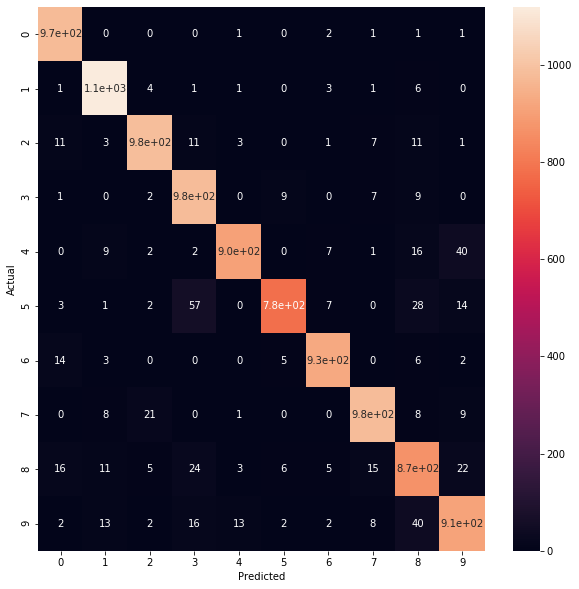

In [34]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': all_labels, 'y_Predicted': all_predictions}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(confusion_matrix, annot=True, ax=ax)